## Linear Sturm-Liouville Problem

### Overview:
For details on problem formulation, visit the data folder and view the dataset for System 1.

Noise: None (0% $\sigma$)

Known Operator? No.


### Learning Goals

Knowns: $f_j(x)$ forcing functions and observed responses $u_j(x)$ 

Unknowns: Operator $L$, parametric coefficients $p(x)$ and $q(x)$

----------------

Input: Observations of $u_j(x)$ and the corresponding forcings $f_j(x)$

Output: Operator $L$, including parametric coefficients $p(x)$ and $q(x)$


In [1]:
%load_ext autoreload
%autoreload 2

# Import Python packages
import pickle

# Third-Party Imports
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Package Imports
from tools.variables import DependentVariable, IndependentVariable
from tools.term_builder import TermBuilder, build_datapools, NoiseMaker
from tools.differentiator import Differentiator, FiniteDiff
from tools.regressions import *
from tools.NoiseMaker import NoiseMaker
from tools.misc import report_learning_results
from tools.plotter3 import Plotter, compute_coefficients
from tools.Grouper import PointwiseGrouper
from tools.GroupRegressor import GroupRegressor

# Use 0 for seeding random state in data randomization (for consistency)
seed = 0
print("Random seed:", seed)

Random seed: 0


In [2]:
## Step 1. Load in the data
file_stem = "./data/S2-NLSL-"

x_array = pickle.load(open(file_stem +"x.pickle", "rb"))
ode_sols = pickle.load(open(file_stem +"sols.pickle", "rb"))
forcings = pickle.load(open(file_stem + "fs.pickle", "rb"))
sl_coeffs = pickle.load(open(file_stem + "coeffs.pickle", "rb"))

## Step 2. Split data into testing and training
num_trials = 10 # Number of trials to use for observation
sol_train, sol_test, f_train, f_test = train_test_split(ode_sols, forcings, train_size=num_trials, random_state = seed)

## Step 3. Build datapool matrices
# Datapools are a matrix of numerically evaluated terms, which will be used to create each $\Theta^(k)$ to learn $\Xi$
differentiator = Differentiator(diff_order = 2, diff_method = 'FD', ) # finite differences
lhs_term = 'd^{2}u/dx^{2}' # Set LHS term for regression
train_dps = build_datapools(sol_train, differentiator, lhs_term, f_train) # build the matrices using training data

## Step 4. Create group regressor and provide optimization function
# Define the regression function as a lambda function which only expects lists of Thetas, LHSs as inputs
RegFunc = lambda Thetas, LHSs: TrainSGTRidge3(Thetas, LHSs, num_tols = 50, lam = 1e-5, epsilon = 1e-6, normalize = 2)

# Create the group regressor (Uses SGTR regression function above)
groupreg = GroupRegressor(RegFunc, PointwiseGrouper(lhs_term = lhs_term), train_dps, 'x')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
%%time
## Step 5. Group regression
groupreg.group_regression()  # Regress operator and coefficients
groupreg.report_learning_results()  # Report the learned coefficients

Possible terms:
['x', 'x^{-1}', 'x^{2}', 'x^{-2}', 'x^{3}', 'x^{-3}', 'x^{4}', 'x^{-4}', 'u', 'u^{2}', 'u^{3}', 'u^{4}', 'u^{5}', 'du/dx', 'u*du/dx', 'u^{2}*du/dx', 'u^{3}*du/dx', 'u^{4}*du/dx', 'u^{5}*du/dx', 'f']

PDE Find Method:
Minimum Error:  -138285.25865730728
Selected:  4  term(s).
u :  20000.008689870265 -19.478514931366476 631.8396428715967
u^{2} :  7.886446845364236 0.18955799427935005 0.16186931994547513
du/dx :  200.33828189999278 0.2243215238195605 6.3281128084705855
f :  10.453377642709968 -0.32748493488558444 0.043789926054884
CPU times: user 37.1 s, sys: 31.7 s, total: 1min 8s
Wall time: 31.2 s


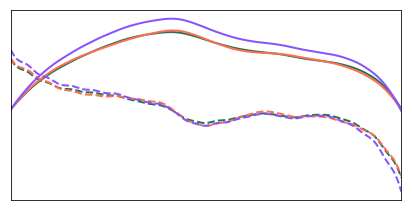

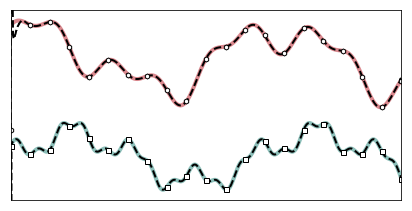

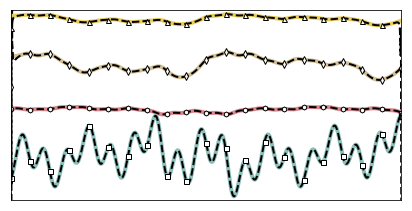

In [18]:
### PLOT RESULTS

# X vector from the first ODE solution
x_vector = ode_sols[0].t

# Construct a plotter object with groupreg (which stores results)
pltr = Plotter(groupreg = groupreg, x_vector = x_vector,
               dependent_variable='u', true_coeffs = sl_coeffs,
               is_sturm_liouville = True, show_legends=False)

# Show results
# Generate the analysis plots: ODE solutions (first 3), p(x) and q(x), and u_xx model coefficients (entries in Xi)
pltr.generate_analysis_plots(save_stem='SI-XiExample', 
                             ode_sols=ode_sols,
                             xi_ylims=[-1,3.2],
                             coeff_ylims=[-1,3])

# Show all the plots (pyplot command)
plt.show()

In [5]:
## Score the true and learned p(x), q(x)
score_interval = [0.1,9.9]
low_idcs = np.where(pltr.true_x_vector > score_interval[0])
high_idcs = np.where(pltr.true_x_vector < score_interval[1])
idcs = np.intersect1d(low_idcs, high_idcs)

p_error = np.linalg.norm(pltr.inferred_phi[idcs] - pltr.p_x[idcs])/np.linalg.norm(pltr.p_x[idcs])
print('L2 p error: %.4f' % (p_error))

q_error = np.linalg.norm(pltr.inferred_q[idcs] - pltr.q_x[idcs])/np.linalg.norm(pltr.q_x[idcs])
print('L2 q error: %.4f' % (q_error))

L2 p error: 0.0003
L2 q error: 0.0124


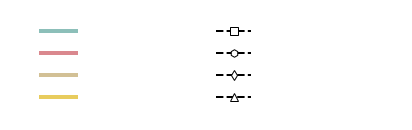

In [16]:
from matplotlib.lines import Line2D
import matplotlib as mpl

fs= pltr.figsize
lcolors = pltr.coeff_colors
markers = pltr.markers
true_opts = pltr.true_opts
reg_opts = pltr.reg_opts

num_colors_to_show = 4
# get the solid lines
custom_lines = [Line2D([0], [0], color=lc, **true_opts) for lc in lcolors][:num_colors_to_show]
# and the corresponding dotted lines
custom_lines += [Line2D([0], [0], marker=mk, **reg_opts) for mk in markers][:num_colors_to_show]
# create labels (no label) for the lines
labels = ['']*len(custom_lines)

# create an Axes to place legend on

fig = plt.figure(figsize=(fs[0],2))
ax = plt.gca()
# Legend placement
mpl.rcParams["legend.markerscale"] = 1.5
mpl.rcParams["legend.labelspacing"] = 1.2
mpl.rcParams["legend.handlelength"] = 3.5
mpl.rcParams["legend.handletextpad"] = 12
ax.legend(custom_lines, labels, frameon=False, loc='center', ncol=2,)
# Remove labels from axes
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
for spine in list(ax.spines):
    ax.spines[spine].set_visible(False)
# Save figure
plt.savefig('./Figs/SI-XiExampleLegend.svg', dpi=600, transparent=True)

# Show all the plots (pyplot command)
plt.show()